# FORESEE - ALP-Photon - Sytematics

### Load Libraries 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import os
import math
import matplotlib
from matplotlib import pyplot as plt
#src_path = "/Users/felixkling/Documents/GitHub/FORESEE/"
src_path = "/Users/abraham/Documents/GitHub/roshanFORESEE/"
sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

/Users/abraham/Documents/GitHub/roshanFORESEE/src/foresee.py:596: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


## 1. Specifying the Model 

Let us specify again the model. But this time 
- we add copies of ch channel with dfferent `n_sample` to test the `n_sample` dependence. 
- we add additional copies of each channel, so that we can infer MC statistical uncertainties. 

Note that we choose the `label` accordingly. 

In [3]:
# Primakoff production has no dependence on nsample
nsamples = [1]
ncopies = 1

generators = ['Pythia8-Forward','EPOSLHC', 'SIBYLL', 'QGSJET']

In [4]:
# initialize
energy = "13.6"
modelname="ALP-photon"
model = Model(modelname, path="./")

        
masses1 = [float(x) for x in ['{:0.4e}'.format(m) for m in np.logspace(-7,-2,25+1)]]
masses2 = [float(x) for x in ['{:0.4e}'.format(m) for m in np.logspace(-2,0,20+1)]]
masses = np.concatenate((masses1,masses2))

model.add_production_direct(
    label = "Prim",
    energy = energy,
    coupling_ref=1,
    masses=masses,
    generator=['Pythia8-Forward','EPOSLHC', 'SIBYLL', 'QGSJET'],
    #generator="EPOSLHC",
)        

# add  ctau and BR
model.set_ctau_1d(filename="model/ctau.txt")

branchings = [
    ["gamma"     , "black"        , "solid"   , r"$\gamma\gamma$"         , 0.110, 0.50],
    ["eegamma"   , "blue"          , "solid"   , r"$ee\gamma$"            , 0.110, 0.03],
]

finalstates=[
    [22,22], [11,-11,22]
]

model.set_br_1d(
    modes=[channel for channel,_,_,_,_,_ in branchings],
    finalstates=finalstates,
    filenames=["model/br/"+channel+".txt" for channel,_,_,_,_,_ in branchings],
)

# finish
foresee = Foresee(path=src_path)
foresee.set_model(model=model)

# Let's also define the detector 
distance, selection, length, luminosity = 474, "np.sqrt(x.x**2 + (x.y+0.065)**2)<.1", 1.5, 60
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity)

## 2. Generate LLP Spectra

Now let's specify the benchmark mass, in this case $m_{A'}=50$ MeV, and produce the corresponding fluxes. 

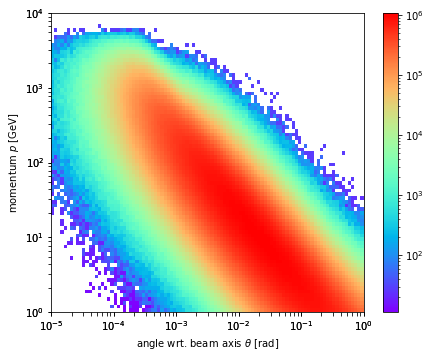

In [8]:
mass=0.05
plot = foresee.get_llp_spectrum(mass=mass, coupling=1.0, do_plot=True, save_file=False)

## 4. Energy Distribution

Let's now make a plot of the energy distribution. 

In [9]:
# define couplings and nsample to use
couplings= [1e-04, 5e-05, 1e-05]
#nsample_use = 100

# initiate summary dict
distributions = {}
edges = np.logspace( 2,  4, num=20+1)
centers = np.logspace( 2.05,  3.95, num=20)

# get numbers
for ncopy in range(ncopies):
    distributions[ncopy] = {}
    modes = {"Prim":generators}
    output = foresee.get_events(mass=mass, energy=energy, couplings=couplings, modes=modes, nsample=30)
    coups, _, _, momenta, weights = output
    for coup, momentum, weight in zip(couplings, momenta, weights):
        distributions[ncopy][coup] = {}
        data = [p.e for p in momentum]
        for igen, generator in enumerate(generators): 
            wgts, _ = np.histogram(data, weights=weight.T[igen], bins=edges)
            distributions[ncopy][coup][generator] = wgts

And now we can plot everything

In [10]:
def plot_energy(distributions, mass, coupling, generators, ncopies, logratio=False, filename=None):

    # initialize
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 14})
    ax1 = fig.add_axes([0.13, 0.40, 0.82, 0.55], xticklabels=[], )
    ax2 = fig.add_axes([0.13, 0.09, 0.82, 0.31],  )
    bins, xvals = np.logspace( 2,  4, num=20+1), np.logspace( 2.05,  3.95, num=20)    
    lines, maxval = {}, 0

    # add data
    maxval,baseline = 0, []
    for igen, generator in enumerate(generators):
        values = np.array([distributions[ncopy][coupling][generator] for ncopy in range (ncopies)]).T
        avg, std = np.array([np.mean(x) for x in values]), np.array([np.std(x) for x in values])
        if igen==0: baseline= avg
        ax1.fill_between(bins[:-1], avg+std, avg-std, step='post', alpha=0.3, label=generator)
        ax1.plot(bins[:-1], avg, drawstyle='steps-post') 
        
        ratio0 = [-1 if x0==0 else x1/x0 for x1,x0 in zip(avg    , baseline)]
        ratio1 = [-1 if x0==0 else x1/x0 for x1,x0 in zip(avg+std, baseline)]
        ratio2 = [-1 if x0==0 else x1/x0 for x1,x0 in zip(avg-std, baseline)]
        ax2.plot(bins[:-1], ratio0, drawstyle='steps-post') 
        ax2.fill_between(bins[:-1], ratio1, ratio2, step='post', alpha=0.3)
        if max(avg+std)>maxval: maxval=max(avg+std) 
        
    # get coupling
    exponent = int(math.floor(np.log10(abs(coupling))))
    prefactor = round(coupling*10**(-exponent),3)
    
    # finalize
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax1.set_xlim(1e2, 1e4)
    ax2.set_xlim(1e2, 1e4)
    ax1.set_ylim(0, 1.1*maxval)
    ax1.set_title(r"m="+str(mass)+"GeV, $\epsilon$="+str(int(prefactor))+"$\cdot 10^{"+str(exponent)+"}$")
    ax2.set_xlabel(r"Energy $E$ [GeV]") 
    ax1.set_ylabel("Number of Decays per Bin") 
    ax2.set_ylabel("Relative to Baseline") 
    ax1.set_xticklabels([])
    if logratio: 
        ax2.set_yscale("log")
        ax2.set_ylim(0.25, 4.)
        ax2.set_yticks([0.33, 0.5, 1, 2, 3])
        ax2.set_yticklabels(["0.33","0.5","1","2","3"])
    else: 
        ax2.set_ylim(0,1.99)   
        
    #legend
    emean = sum([e*n for e,n in zip(bins, baseline)])/sum(baseline)
    if emean>1000: ax1.legend(frameon=False, labelspacing=0, loc="upper left")
    else: ax1.legend(frameon=False, labelspacing=0, loc="upper right")

    #save
    #fig.subplots_adjust(wspace=0, hspace=0, left=0.07, right=0.975, bottom=0.07, top=0.95 )
    if filename is not None: plt.savefig(filename)
    plt.show()

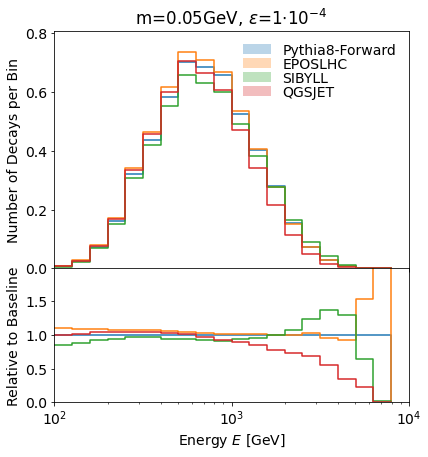

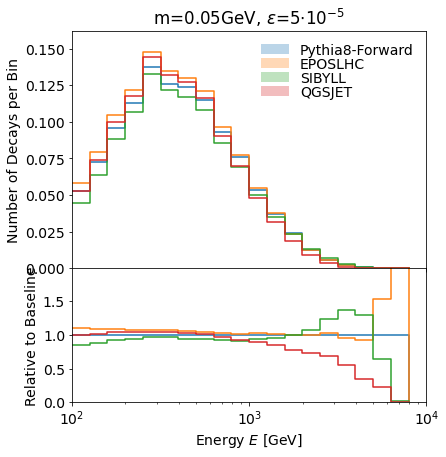

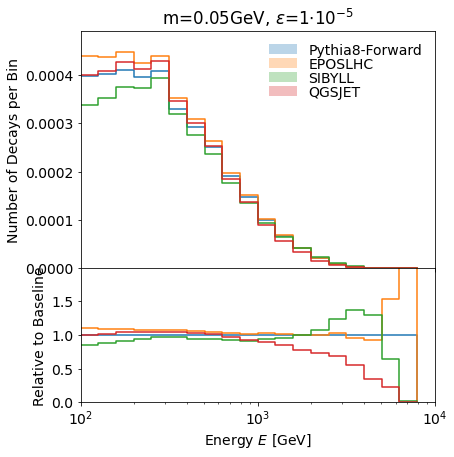

In [11]:
for coupling in couplings: 
    filename = "figures/"+modelname+"_Energy_"+str(mass)+"_"+str(coupling)+".pdf"
    plot_energy(distributions, mass, coupling, generators, ncopies, filename=filename)